In [4]:
import neptune.new as neptune
import os
run = neptune.init(
    project=os.environ['NEPTUNE_PROJECT'],
    api_token=os.environ['NEPTUNE_API_TOKEN'])


https://app.neptune.ai/bonnefond.virginie/initial-project/e/IN-2


Info (NVML): NVML Shared Library Not Found. GPU usage metrics may not be reported. For more information, see https://docs.neptune.ai/you-should-know/what-can-you-log-and-display#hardware-consumption


Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor

# Get dataset

In [6]:
# https://archive.ics.uci.edu/ml/datasets/abalone
data = pd.read_csv("../toy_datasets/regressions/abalone.csv", header=None)
data.columns=["sex", "length", "diameter", "height", "whole_weight", 
              "shucked_weight", "viscera_weight", "shell_weight", "rings"]
data.tail()

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
4172,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11
4173,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10
4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9
4175,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10
4176,M,0.710,0.555,0.195,1.9485,0.9455,0.3765,0.4950,12


# Heteroscedasticity
The scattering is not constant across the range of rings.

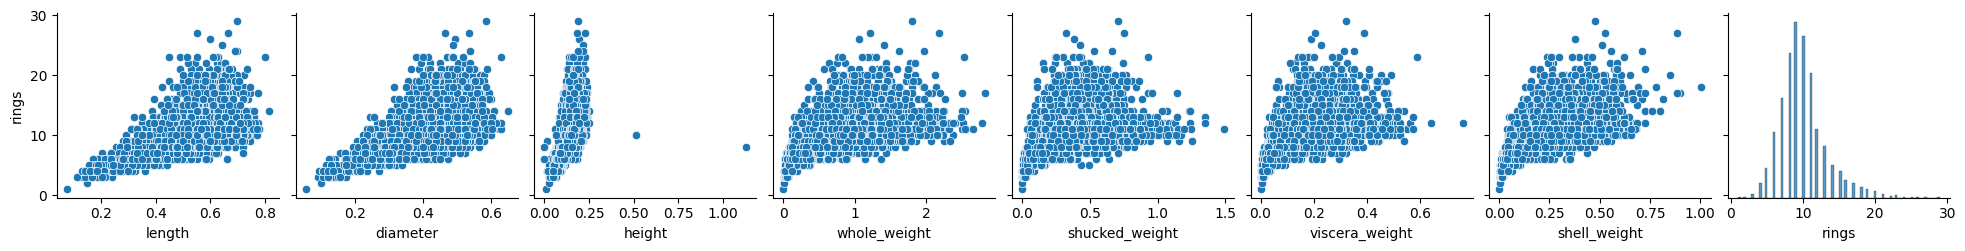

In [7]:
sns.pairplot(data=data, y_vars=['rings'])
plt.show()

# Quantile Regressions with LightGBM
https://medium.com/dataman-in-ai/a-tutorial-on-quantile-regression-quantile-random-forests-and-quantile-gbm-d3c651af7516

In [8]:
%%time
params = {"test_size":0.2, "shuffle": True}
prediction_interval = 0.5
train_df, test_df = train_test_split(data, **params)
features = ['length', 'diameter', 'height', 'whole_weight', 'shucked_weight','viscera_weight', 'shell_weight']

run["parameters"] = params
run["features"] = features

target = "rings"
X_train, y_train = train_df[features], train_df[target].to_numpy()
X_test, y_test = test_df[features], test_df[target].to_numpy()
content = []
for tau in [(1-prediction_interval)/2, 0.5, 1-(1-prediction_interval)/2]:
    clf = LGBMRegressor(objective='quantile', alpha=tau)
    clf.fit(X_train, y_train)
    preds = pd.DataFrame(clf.predict(X_test), columns = [str(tau)])
    content.append(preds)
preds = pd.concat(content, axis=1)
preds["actual"] = y_test
preds.sample(5)

CPU times: user 2.24 s, sys: 0 ns, total: 2.24 s
Wall time: 198 ms


,0.25,0.5,0.75,actual
711,8.110272,9.206797,9.708887,9
776,7.723899,8.523125,9.204757,8
486,3.468144,4.000377,4.936152,4
95,4.866166,5.205001,5.643206,5
405,7.771604,8.413276,10.694030,8


# Visualisations

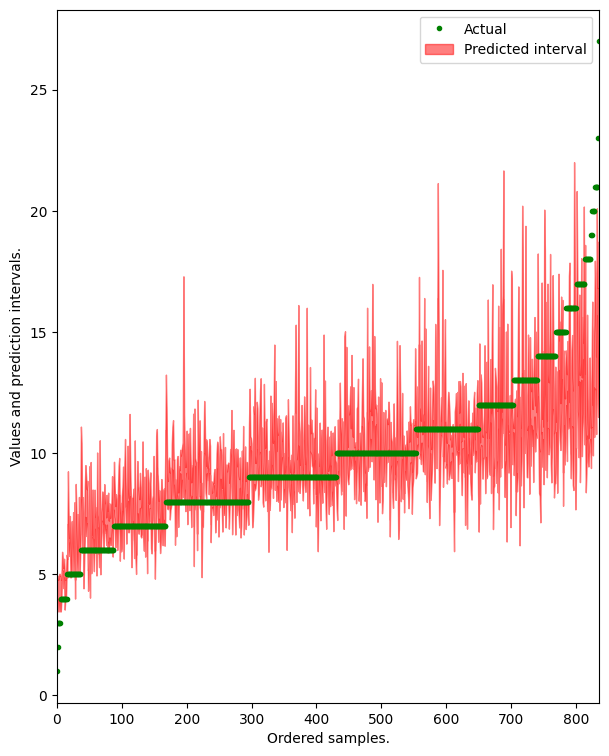

In [9]:
preds = preds.sort_values(by="actual").reset_index(drop=True)

def showIntervals(df):    
    fig = plt.figure(figsize=(7, 9))
    plt.plot(df['actual'],'go',markersize=3,label='Actual')
    plt.fill_between(
        np.arange(len(df)), df[df.columns[0]], df[df.columns[2]], alpha=0.5, color="r",
        label="Predicted interval")
    plt.xlabel("Ordered samples.")
    plt.ylabel("Values and prediction intervals.")
    plt.xlim([0, len(df)])
    plt.legend()
    plt.show()
    return fig
    
fig = showIntervals(preds)
run["matplotlib-fig"].upload(fig)
preds["in_interval"] = preds.apply(lambda row: True if row[preds.columns[0]]<=row.actual<row[preds.columns[2]] else False, axis=1)

In [10]:
prediction_interval

0.5

In [11]:
from neptune.new.types import File

# Pandas DataFrame
run["data/sample"].upload(File.as_html(preds))

In [12]:
run.stop()

Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 19 operations to synchronize with Neptune. Do not kill this process.


All 19 operations synced, thanks for waiting!


Ideally, we would expect the "in_interval" and "prediction_interval" variables to be almost matching.

In [13]:
neptune.init??

Signature:
neptune.init(
    project: Union[str, NoneType] = None,
    api_token: Union[str, NoneType] = None,
    run: Union[str, NoneType] = None,
    custom_run_id: Union[str, NoneType] = None,
    mode: str = 'async',
    name: Union[str, NoneType] = None,
    description: Union[str, NoneType] = None,
    tags: Union[List[str], str, NoneType] = None,
    source_files: Union[List[str], str, NoneType] = None,
    capture_stdout: bool = True,
    capture_stderr: bool = True,
    capture_hardware_metrics: bool = True,
    fail_on_exception: bool = True,
    monitoring_namespace: Union[str, NoneType] = None,
    flush_period: float = 5,
    proxies: Union[dict, NoneType] = None,
    capture_traceback: bool = True,
    **kwargs,
) -> neptune.new.metadata_containers.run.Run
Source:   
def init_run(
    project: Optional[str] = None,
    api_token: Optional[str] = None,
    run: Optional[str] = None,
    custom_run_id: Optional[str] = None,
    mode: str = Mode.ASYNC.value,
    name: Optio